## CMPE538. Project 2.B

In Project 2B, We project 3D skeleton joints via camera parameters and get 2D joints. Then, Plot 2D joints on the image. Using 2D keypoints and Camera parameters for chosen two cameras, we do stereo 3D reconstruction and get a 3D skeleton. By using 2D GT, reconstruction error is expected to be low. Then, we will use a 2D pose finder (oponpose, mediapipe etc) to collect 2D predictions for chosen cameras. Then, we will apply stereo reconstruction (triangulation) to 2D joint predictions and get a 3D skeleton. By using 2D prediction in 3D reconstruction, we expect higher errors.

(Do not install Openpose, Mediapipe to your local PC, Try Colabs given. I want you to try these tools. In the following days, we can share 2D skeleton predictions in the the hw forum.) 

Please fill your info.

Name/Surname: Emre Girgin

E-mail: emre.girgin@boun.edu.tr

Student No: 2021700060


In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

# For camera projection (with distortion)
import panutils

In [2]:
# Setup paths
data_path = '../'
seq_name = '171204_pose1_sample'
hd_img_path = data_path+seq_name+'/hdImgs/'

## Load camera calibration parameters

In [3]:
# Load camera calibration parameters
with open(data_path+seq_name+'/calibration_{0}.json'.format(seq_name)) as cfile:
    calib = json.load(cfile)

# Cameras are identified by a tuple of (panel#,node#)
cameras = {(cam['panel'],cam['node']):cam for cam in calib['cameras']}

# Convert data into numpy arrays for convenience
for k,cam in cameras.items():    
    cam['K'] = np.matrix(cam['K'])
    cam['distCoef'] = np.array(cam['distCoef'])
    cam['R'] = np.matrix(cam['R'])
    cam['t'] = np.array(cam['t']).reshape((3,1))
    

## Reproject 3D Body Keypoint via Cam 21

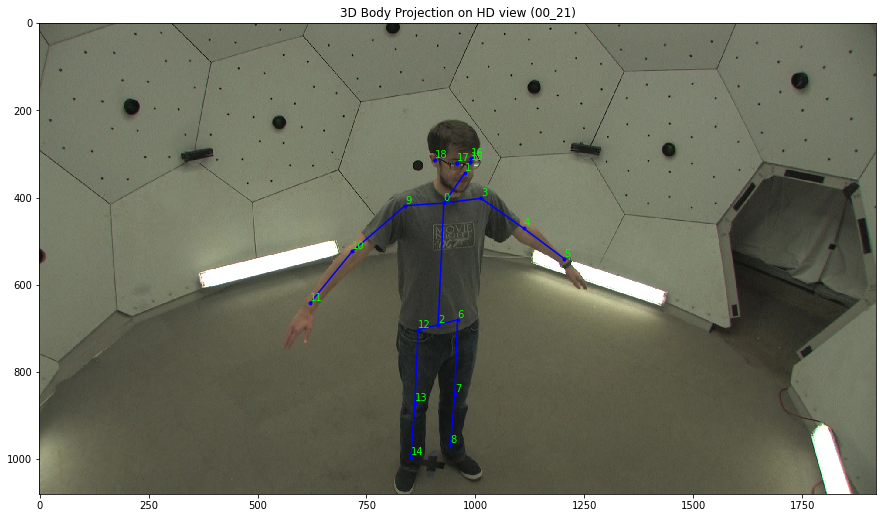

In [4]:
'''
## Reproject 3D Body Keypoint onto the first HD camera
'''
# Select HD frame
hd_idx = 42


# Select an HD camera (0,0) - (0,30), where the zero in the first index means HD camera 
cam = cameras[(0,21)]


# Load the corresponding HD image
image_path = hd_img_path+'{0:02d}_{1:02d}/{0:02d}_{1:02d}_{2:08d}.jpg'.format(cam['panel'], cam['node'], hd_idx)
im = plt.imread(image_path)


# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1

plt.figure(figsize=(15,15))
plt.title('3D Body Projection on HD view ({0})'.format(cam['name']))
plt.imshow(im)
currentAxis = plt.gca()
currentAxis.set_autoscale_on(False)



# Load frame's skeletons
skel3D = np.load('3D_GT_skels.npy')
skel = skel3D[hd_idx].T #get 3D GT Skel for frame 42

# Project skeleton into view 
pt = panutils.projectPoints(skel[0:3,:],
              cam['K'], cam['R'], cam['t'], 
              cam['distCoef'])

plt.plot(pt[0], pt[1], '.', color=[0,0,1])

# Plot edges for each bone
for edge in body_edges:
    plt.plot(pt[0,edge], pt[1,edge], color=[0,0,1])

# Show the joint numbers
for ip in range(pt.shape[1]):
    plt.text(pt[0,ip], pt[1,ip]-5, '{0}'.format(ip),color=[0,1,0])

plt.draw()



##  3D Reconstruction from 2D Skeletons (Cam 17 and Cam 21)

2D GT Skeletons for Cam 17 and Cam 21 are given: points17, points21

In [5]:
### Cam 17 : Get 2D GT Skeleton 
cam17 = cameras[(0,17)]
pt17 = panutils.projectPoints(skel[0:3,:],
              cam17['K'], cam17['R'], cam17['t'], 
              cam17['distCoef'])

#2D GT Skeleton from Cam 17
points17 = pt17[:2].T

### Cam 21 : Get 2D GT Skeleton
cam21 = cameras[(0,21)]
pt21 = panutils.projectPoints(skel[0:3,:],
              cam21['K'], cam21['R'], cam21['t'], 
              cam21['distCoef'])

#2D GT Skeleton from Cam 21
points21 = pt21[:2].T

In [6]:
# Use Camera Parameters (K,R,t) and given 2D skeletons (Cam 17 and 21), 
# Reconstruct a 3D skeleton for frame 42. 
# Remember, we have 19 2D point-correspondences. (Skeleton has 19 joints)

###################################################################
# HERE !
def construct_camera_matrix(intrinsic, rotation, translation, distortion):
    # TODO: Distortion ?
    extrinsic = np.hstack((rotation, translation))
    return np.dot(intrinsic, extrinsic)
    
def construct_ls_matrix(P17, P21, x17, x21):
    return np.vstack((
        x17[0] * P17[2] - P17[0],
        x17[1] * P17[2] - P17[1],
        
        x21[0] * P21[2] - P21[0],
        x21[1] * P21[2] - P21[1]        
    ))

def find_3D_points(cam1_matrix, cam2_matrix, points1, points2):
    
    skel3d = np.zeros((3, points1.shape[0]))
        
    for i in range(points1.shape[0]):
        
        A = construct_ls_matrix(cam1_matrix, cam2_matrix, points1[i], points2[i])

        U,S,V_T = np.linalg.svd(A)
    
        p_homogeneous = np.ravel(V_T[-1])
        
        p_homogeneous /= p_homogeneous[-1]
        
        skel3d[:, i] = p_homogeneous[:-1]
    
    return skel3d

P17 = construct_camera_matrix(cam17["K"], cam17["R"], cam17["t"], cam17["distCoef"])

P21 = construct_camera_matrix(cam21["K"], cam21["R"], cam21["t"], cam21["distCoef"])

# Mean Per Joint Position Error
def MPJPE(skel1,skel2):
    
    assert skel1.shape ==skel2.shape
    
    error = 0.0

    for i in range(skel1.shape[1]):
        error += np.linalg.norm(skel1[:,i] - skel2[:, i])
    
    return error / skel1.shape[1] # the mean

# skel3d = ??? # 3D Skeleton reconst for frame 42 from cam 17,21. 
###################################################################

### Calculate MPJPE Error  between GT 3D skeleton and Reconstruction 3D Skeleton. (For frame 42)

In [7]:
# Load frame's skeletons
skel3D = np.load('3D_GT_skels.npy')
skel42 = skel3D[hd_idx].T # skel 42 -> GT 3D Skeleton

###################################################################
# HERE ! 
skel3d = find_3D_points(P17, P21, points17, points21) #Use 3D skeleton reconstruction from 2D GT skeletons#
###################################################################

#3D stereo reconstrution error (Cam 17 - Cam 21) againts GT.
print(f"MPJPE [Reconst. using Cam 17-21 againt 3D GT] : {MPJPE(skel42,skel3d)} mm.")

MPJPE [Reconst. using Cam 17-21 againt 3D GT] : 0.7226174397292919 mm.


## Using 2D Pose Finder (OpenPose, Medipipe etc)
#### Pick 2D Pose finder, Get 2D predictions, Reconst. 3D skel. from 2D preds.
#### Be aware of skeleton conversion. You can simplify skeletons by dropping some joints like faces. 
#### Calculate MPJPE, PA-MPJPE for frame 42. 
#### Plot 3D Pred. skeleton with 3D GT. 

-- CMU Sketon --
0: Neck
1: Nose
2: BodyCenter (center of hips)
3: lShoulder
4: lElbow
5: lWrist,
6: lHip
7: lKnee
8: lAnkle
9: rShoulder
10: rElbow
11: rWrist
12: rHip
13: rKnee
14: rAnkle
15: lEye
16: lEar
17: rEye
18: rEar

- https://github.com/CMU-Perceptual-Computing-Lab/panoptic-toolbox

- MEDIAPIPE: https://colab.research.google.com/github/kevinash/awesome-ai/blob/main/notebooks/6_PosesAndAction/Pose_MediaPipe.ipynb#scrollTo=e9AYxAaG9_uO


In [8]:
###################################################################
# HERE !
# Step 1:
# Get 2D Skeleton Predictionss from openpose, mediapipe (Do Not Install Openpose/Mediapipe).

import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

cam17 = cameras[(0,17)] # 
cam21 = cameras[(0,21)] # 

# Load the corresponding HD image
image_path17 = hd_img_path+'{0:02d}_{1:02d}/{0:02d}_{1:02d}_{2:08d}.jpg'.format(cam17['panel'], cam17['node'], hd_idx)
image_path21 = hd_img_path+'{0:02d}_{1:02d}/{0:02d}_{1:02d}_{2:08d}.jpg'.format(cam21['panel'], cam21['node'], hd_idx)

im17  = plt.imread(image_path17)
im21 = plt.imread(image_path21)

pred_points17 = pose.process(im17)
pred_points21 = pose.process(im21)


# Step 2:
# Check whether Skeleton conversion between CMU Skeleton and Oponpose Skeleton. 
# If necessary, convert prediction 2D Skeleton to CMU format.

def mediapipe2CMU(mediapipe_points, img_width, img_height):
    cmu_format = np.zeros((2, 19))
    ## NECK & SHOULDERS
    left_shoulder_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * img_width
    left_shoulder_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * img_height
    
    cmu_format[0, 3] = left_shoulder_x
    cmu_format[1, 3] = left_shoulder_y
    
    right_shoulder_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * img_width
    right_shoulder_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * img_height
    
    cmu_format[0, 9] = right_shoulder_x
    cmu_format[1, 9] = right_shoulder_y
    
    neck_x = int((left_shoulder_x + right_shoulder_x) / 2)
    neck_y = int((left_shoulder_y + right_shoulder_y) / 2)
    
    cmu_format[0, 0] = neck_x
    cmu_format[1, 0] = neck_y
    
    ## NOSE
    nose_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * img_width
    nose_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * img_height
    
    cmu_format[0, 1] = nose_x
    cmu_format[1, 1] = nose_y
    
    ## CENTER & HIP
    
    left_hip_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x * img_width
    left_hip_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y * img_height
    
    cmu_format[0, 6] = left_hip_x
    cmu_format[1, 6] = left_hip_y
    
    right_hip_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x * img_width
    right_hip_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y * img_height
    
    cmu_format[0, 12] = right_hip_x
    cmu_format[1, 12] = right_hip_y
    
    center_x = int((left_hip_x + right_hip_x) / 2)
    center_y = int((left_hip_y + right_hip_y) / 2)
    
    cmu_format[0, 2] = center_x
    cmu_format[1, 2] = center_y
    
    ## ELBOW
    left_elbow_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].x * img_width
    left_elbow_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].y * img_height
    
    cmu_format[0, 4] = left_elbow_x
    cmu_format[1, 4] = left_elbow_y
    
    right_elbow_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].x * img_width
    right_elbow_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].y * img_height
    
    cmu_format[0, 10] = right_elbow_x
    cmu_format[1, 10] = right_elbow_y
    
    ## WRIST
    left_wrist_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x * img_width
    left_wrist_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y * img_height
    
    cmu_format[0, 5] = left_wrist_x
    cmu_format[1, 5] = left_wrist_y
    
    right_wrist_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x * img_width
    right_wrist_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y * img_height
    
    cmu_format[0, 11] = right_wrist_x
    cmu_format[1, 11] = right_wrist_y
    
    ## KNEE
    
    left_knee_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE].x * img_width
    left_knee_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE].y * img_height
    
    cmu_format[0, 7] = left_knee_x
    cmu_format[1, 7] = left_knee_y
    
    right_knee_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].x * img_width
    right_knee_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].y * img_height
    
    cmu_format[0, 13] = right_knee_x
    cmu_format[1, 13] = right_knee_y
    
    ## ANKLE
    
    left_ankle_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].x * img_width
    left_ankle_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].y * img_height
    
    cmu_format[0, 8] = left_ankle_x
    cmu_format[1, 8] = left_ankle_y
    
    right_ankle_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * img_width
    right_ankle_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * img_height
    
    cmu_format[0, 14] = right_ankle_x
    cmu_format[1, 14] = right_ankle_y
    
    ## EYE
    left_eye_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EYE].x * img_width
    left_eye_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EYE].y * img_height
    
    cmu_format[0, 15] = left_eye_x
    cmu_format[1, 15] = left_eye_y
    
    right_eye_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EYE].x * img_width
    right_eye_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EYE].y * img_height
    
    cmu_format[0, 17] = right_eye_x
    cmu_format[1, 17] = right_eye_y
    
    
    ## EAR
    
    left_ear_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].x * img_width
    left_ear_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].y * img_height
    
    cmu_format[0, 16] = left_ear_x
    cmu_format[1, 16] = left_ear_y
    
    right_ear_x = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].x * img_width
    right_ear_y = mediapipe_points.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].y * img_height
    
    cmu_format[0, 18] = right_ear_x
    cmu_format[1, 18] = right_ear_y
    
    
    return cmu_format.T

pred_points17_cmu = mediapipe2CMU(pred_points17, im17.shape[1], im17.shape[0])
pred_points21_cmu = mediapipe2CMU(pred_points21, im21.shape[1], im21.shape[0])

# Step 3:
# Reconstruct 3D skeleton from two 2D skeleton predictions.
pred_3d = find_3D_points(P17, P21, pred_points17_cmu, pred_points21_cmu)
# Step 4:
# Calculate MPJPE between 3D GT and 3D Reconstruction (from openpose/mediapipe predictions.)
print(f"MPJPE [Reconst. using Cam 17-21 against 3D Mediapipe Predictions] : {MPJPE(skel42, pred_3d)} mm.")
###################################################################

MPJPE [Reconst. using Cam 17-21 against 3D Mediapipe Predictions] : 4.190789832050263 mm.


### References
1 -

2 -

3 -
